In [1]:
from __future__ import print_function
from keras import backend as K
from keras import activations
from keras import utils
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import regularizers
from glob import glob
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

IMG_SIZE = 299
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
def DataGenerator(train_batch, val_batch, IMG_SIZE):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255,
                                 rotation_range=10,
                                 horizontal_flip=True,
                                 vertical_flip=True)

    datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

    train_gen = datagen.flow_from_directory('../input/mydata/train',
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            color_mode='rgb', 
                                            class_mode='categorical',
                                            batch_size=train_batch)

    val_gen = datagen.flow_from_directory('../input/mydata/test', 
                                          target_size=(IMG_SIZE, IMG_SIZE),
                                          color_mode='rgb', 
                                          class_mode='categorical',
                                          batch_size=val_batch)

    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255)
    
    datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

    test_gen = datagen.flow_from_directory('../input/mydata/test', 
                                           target_size=(IMG_SIZE, IMG_SIZE),
                                           color_mode='rgb', 
                                           class_mode='categorical',
                                           shuffle=False)
    
    return train_gen, val_gen, test_gen

In [3]:
# the squashing function.
# we use 0.5 in stead of 1 in hinton's paper.
# if 1, the norm of vector will be zoomed out.
# if 0.5, the norm will be zoomed in while original norm is less than 0.5
# and be zoomed out while original norm is greater than 0.5.
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x

In [4]:
# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

In [5]:
# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1 #default lambda 0.5 - but test with lambda with 0.9 - 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)

In [6]:
class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3, # Test number of routing with (1, 2, 3, 4) - Default = 3
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [7]:
train_batch = 32
val_batch = 1

train, val, test = DataGenerator(train_batch, val_batch, IMG_SIZE)

Found 343 images belonging to 2 classes.
Found 174 images belonging to 2 classes.
Found 174 images belonging to 2 classes.


In [8]:
input_image = Input(shape=(IMG_SIZE, IMG_SIZE, 3))


# A InceptionResNetV2 Conv2D model
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_image)

base_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool

In [9]:
for layer in base_model.layers:
    layer.trainable = False
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe3b8dc8780> False
<keras.layers.convolutional.Conv2D object at 0x7fe3b8dc8d68> False
<keras.layers.convolutional.Conv2D object at 0x7fe37521bb38> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe375224780> False
<keras.layers.convolutional.Conv2D object at 0x7fe375224208> False
<keras.layers.convolutional.Conv2D object at 0x7fe374759c88> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe3746f4cc0> False
<keras.layers.convolutional.Conv2D object at 0x7fe3746f47f0> False
<keras.layers.convolutional.Conv2D object at 0x7fe374725ba8> False
<keras.layers.convolutional.Conv2D object at 0x7fe3746bfe80> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe374672080> False
<keras.layers.convolutional.Conv2D object at 0x7fe3746d39b0> False
<keras.layers.convolutional.Conv2D object at 0x7fe37468f0f0> False
<keras.layers.convolutional.Conv2D object at 0x7fe3746a4a20> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe37463fef0>

In [10]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=input_image, outputs=output)

model.summary()
#for plottting added
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='VGG_07_03_21.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0         
__________

In [11]:
lr=1e-4

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=lr), metrics=['accuracy'])

In [12]:
history1=model.fit_generator(train,
                    epochs=1,
                    validation_data=val, 
                    validation_steps = len(val.classes)//val_batch,
                    steps_per_epoch=(len(train.classes)//train_batch) * 2) 
    
loss, acc = model.evaluate_generator(test, len(test))

print ("\n\n================================\n\n")
print ("Loss: {}".format(loss))
print ("Accuracy: {0:.2f} %".format(acc * 100))
print ("\n\n================================\n\n")


test.reset()

Epoch 1/1
20/20 [==============================] - 25s 1s/step - loss: 0.5274 - acc: 0.7557 - val_loss: 0.4050 - val_acc: 0.9943




Loss: 0.39334644565637084
Accuracy: 99.43 %






In [13]:
for i, layer in enumerate(model.layers):
    if i < 15:
        layer.trainable = False
    else:
        layer.trainable = True

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=lr, momentum=0.9), metrics=['accuracy'])

Epoch 1/10
20/20 [==============================] - 20s 1s/step - loss: 0.4004 - acc: 0.9054 - val_loss: 0.3581 - val_acc: 0.9943
Epoch 2/10
20/20 [==============================] - 17s 835ms/step - loss: 0.3726 - acc: 0.8813 - val_loss: 0.3189 - val_acc: 0.9943
Epoch 3/10
20/20 [==============================] - 16s 796ms/step - loss: 0.3233 - acc: 0.9101 - val_loss: 0.2771 - val_acc: 0.9943
Epoch 4/10
20/20 [==============================] - 17s 843ms/step - loss: 0.2966 - acc: 0.9019 - val_loss: 0.2476 - val_acc: 0.9943
Epoch 5/10
20/20 [==============================] - 16s 814ms/step - loss: 0.2721 - acc: 0.9085 - val_loss: 0.2146 - val_acc: 0.9943
Epoch 6/10
20/20 [==============================] - 17s 834ms/step - loss: 0.2614 - acc: 0.9089 - val_loss: 0.2000 - val_acc: 0.9943
Epoch 7/10
20/20 [==============================] - 16s 795ms/step - loss: 0.2435 - acc: 0.9214 - val_loss: 0.1923 - val_acc: 0.9943
Epoch 8/10
20/20 [==============================] - 17s 833ms/step - los

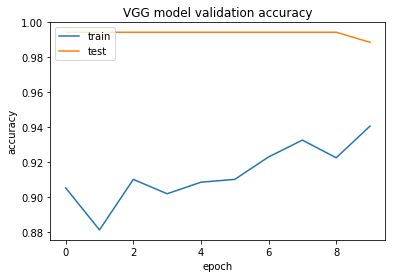

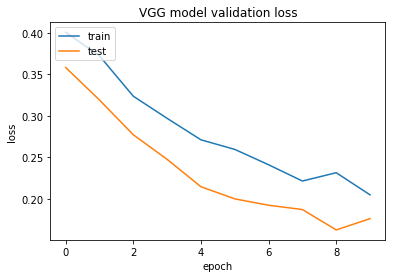





Loss: 0.16560805713136992
Accuracy: 98.28 %






In [15]:
model1=model.fit_generator(train,
                    epochs=10,
                    validation_data=val, 
                    validation_steps = len(val.classes)//val_batch,
                    steps_per_epoch=(len(train.classes)//train_batch) * 2) 
    


##for plottting addnew ____
plt.plot(model1.history['acc'])
plt.plot(model1.history['val_acc'])
plt.title('VGG model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.title('VGG model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


##-----------


loss, acc = model.evaluate_generator(test, len(test))

print ("\n\n================================\n\n")
print ("Loss: {}".format(loss))
print ("Accuracy: {0:.2f} %".format(acc * 100))
print ("\n\n================================\n\n")
test.reset()

In [16]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255)
    
datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

test_gen = datagen.flow_from_directory('../input/mydata/test', 
                                           target_size=(IMG_SIZE, IMG_SIZE),
                                           color_mode='rgb', 
                                           class_mode='categorical',
                                           shuffle=False)

Found 174 images belonging to 2 classes.


In [17]:
Y_pred = model.predict_generator(test_gen, 174 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
print('Confusion Matrix')
#print(val_gen.classes)
cm=confusion_matrix(test_gen.classes, y_pred)

print('Classification Report')
target_names = ['normal', 'cancer']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      normal       0.99      0.98      0.99       120
      cancer       0.96      0.98      0.97        54

    accuracy                           0.98       174
   macro avg       0.98      0.98      0.98       174
weighted avg       0.98      0.98      0.98       174



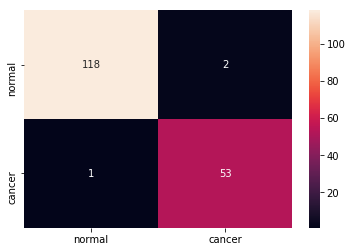

In [18]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d',xticklabels=target_names, yticklabels=target_names)

In [19]:
output = Conv2D(256, kernel_size=(9, 9), strides=(1, 1), activation='relu')(base_model.get_layer(name='block5_pool').output)

x = Reshape((-1, 256))(output)
capsule = Capsule(2, 16, 4, True)(x)
output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model = Model(inputs=input_image, outputs=output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0         
__________

In [20]:
lr=1e-4

checkpoint = ModelCheckpoint("07_march_weights.h5", 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='min')

early = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min', restore_best_weights=True)

callback_list = [checkpoint, early]

Epoch 1/10
10/10 [==============================] - 14s 1s/step - loss: 0.1576 - acc: 0.7973 - val_loss: 0.1290 - val_acc: 0.8218

Epoch 00001: val_loss improved from inf to 0.12900, saving model to 07_march_weights.h5
Epoch 2/10
10/10 [==============================] - 9s 939ms/step - loss: 0.0576 - acc: 0.9331 - val_loss: 0.0219 - val_acc: 0.9885

Epoch 00002: val_loss improved from 0.12900 to 0.02188, saving model to 07_march_weights.h5
Epoch 3/10
10/10 [==============================] - 10s 985ms/step - loss: 0.0429 - acc: 0.9539 - val_loss: 0.0175 - val_acc: 0.9943

Epoch 00003: val_loss improved from 0.02188 to 0.01755, saving model to 07_march_weights.h5
Epoch 4/10
10/10 [==============================] - 10s 1s/step - loss: 0.0289 - acc: 0.9563 - val_loss: 0.0133 - val_acc: 0.9943

Epoch 00004: val_loss improved from 0.01755 to 0.01326, saving model to 07_march_weights.h5
Epoch 5/10
10/10 [==============================] - 10s 1s/step - loss: 0.0255 - acc: 0.9843 - val_loss: 0.

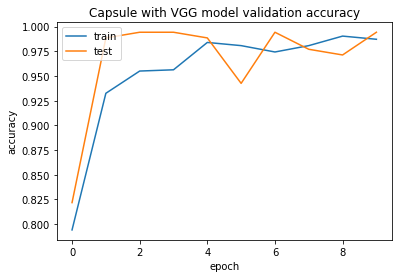

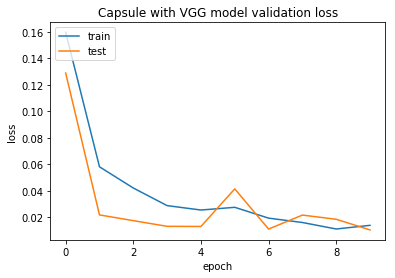





Loss: 0.007863507592289886
Accuracy: 99.43 %






In [21]:
epochs=10   #change from 100 to 20

model.compile(loss=margin_loss, optimizer=SGD(lr=lr, momentum=0.9), metrics=['accuracy'])

model2=model.fit_generator(train,
                    epochs=epochs,
                    validation_data=val, 
                    validation_steps = len(val.classes)//val_batch,
                    steps_per_epoch=len(train.classes)//train_batch,
                    callbacks=callback_list)
    


##for plottting addnew ____
plt.plot(model2.history['acc'])
plt.plot(model2.history['val_acc'])
plt.title('Capsule with VGG model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model2.history['loss'])
plt.plot(model2.history['val_loss'])
plt.title('Capsule with VGG model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


##-----------
loss, acc = model.evaluate_generator(test, len(test))

print ("\n\n================================\n\n")
print ("Loss: {}".format(loss))
print ("Accuracy: {0:.2f} %".format(acc * 100))
print ("\n\n================================\n\n")
test.reset()

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [23]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255)
    
datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

test_gen = datagen.flow_from_directory('../input/mydata/test', 
                                           target_size=(IMG_SIZE, IMG_SIZE),
                                           color_mode='rgb', 
                                           class_mode='categorical',
                                           shuffle=False)

Found 174 images belonging to 2 classes.


In [24]:
Y_pred = model.predict_generator(test_gen, 174 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
print('Confusion Matrix')
cm=confusion_matrix(test_gen.classes, y_pred)

print('Classification Report')
target_names = ['normal', 'cancer']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      normal       0.99      1.00      1.00       120
      cancer       1.00      0.98      0.99        54

    accuracy                           0.99       174
   macro avg       1.00      0.99      0.99       174
weighted avg       0.99      0.99      0.99       174



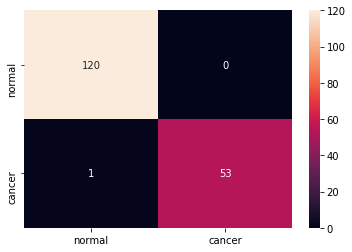

In [25]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d',xticklabels=target_names, yticklabels=target_names)